In [ ]:
!pip install pandas==1.0.3 regex matplotlib==3.2.1 cython grpcio-tools scikit-learn pyarrow fastparquet plotly memoized-property opt-einsum==2.3.2 > /dev/null 2>&1

In [ ]:
!pip install --upgrade git+https://github.com/frreiss/text-extensions-for-pandas > /dev/null 2>&1

In [ ]:
%load util.py

# analyze_fit_us_data.ipynb

Analyze the curves that `fit_us_data.ipynb` fits to the COVID-19 time series.

Inputs:
* `data/us_counties_curves.csv`: Curves fit by `bgfs.ipynb`
* `data/us_counties_curves_meta.json`: Column type metadata for reading `data/us_counties_curves.csv` with `pd.read_csv()`
* `data/us_counties_curves_params.csv`: Model parameters corresponding to the curves in `data/us_counties_curves.csv`

In [1]:
# Initialization boilerplate

# Ensure a consistent Python environment.
#import sys
#sys.path.append("..")  # Local libraries are in the directory above "notebooks"
#import env
#env.maybe_install_libs()

import os
import json
import pandas as pd
import numpy as np
import scipy.optimize
from sklearn import metrics

from typing import *

import text_extensions_for_pandas as tp

# Local file of utility functions
import util

_DATA_DIR = os.getenv('COVID_DATA_DIR', '../data')

In [2]:
# Read in the CSV file and apply the saved type information
csv_file = os.path.join(_DATA_DIR, "us_counties_curves.csv")
meta_file = os.path.join(_DATA_DIR, "us_counties_curves_meta.json")

# Read column type metadata
with open(meta_file) as f:
    curves_meta = json.load(f)

# Pandas does not currently support parsing datetime64 from CSV files.
# As a workaround, read the "Date" column as objects and manually 
# convert after.
curves_meta["Date"] = "object"

curves_vertical = (
    pd
    .read_csv(csv_file, dtype=curves_meta, parse_dates=["Date"])   
    .set_index(["FIPS", "Date"], verify_integrity=True)
)
curves_vertical

State   County  Population  Confirmed  Confirmed_Outlier  \
FIPS  Date                                                                     
1003  2020-03-10  Alabama  Baldwin      223234          0              False   
      2020-03-11  Alabama  Baldwin      223234          0              False   
      2020-03-12  Alabama  Baldwin      223234          0              False   
      2020-03-13  Alabama  Baldwin      223234          0              False   
      2020-03-14  Alabama  Baldwin      223234          0              False   
...                   ...      ...         ...        ...                ...   
56021 2020-04-23  Wyoming  Laramie       99500        117              False   
      2020-04-24  Wyoming  Laramie       99500        120              False   
      2020-04-25  Wyoming  Laramie       99500        124              False   
      2020-04-26  Wyoming  Laramie       99500        125              False   
      2020-04-27  Wyoming  Laramie       99500        128              False   

                  Exponential    Logistic   Logistic2  
FIPS  Date                                             
1003  2020-03-10     1.000000    0.962989    0.111236  
      2020-03-11     1.118203    1.109625    0.146883  
      2020-03-12     1.250379    1.278442    0.193740  
      2020-03-13     1.398178    1.472747    0.255204  
      2020-03-14     1.563447    1.696327    0.335638  
...                       ...         ...         ...  
56021 2020-04-23   108.186079  108.815338  120.583026  
      2020-04-24   120.337933  114.217999  119.201836  
      2020-04-25   133.854728  119.653801  118.473510  
      2020-04-26   148.889778  125.101474  118.301737  
      2020-04-27   165.613620  130.539563  118.603007  

[32389 rows x 8 columns]

In [3]:
# Name of the column that bgfs.ipynb analyzed
ts_col_name = "Confirmed"
outlier_col_name = ts_col_name + "_Outlier"
metadata_cols = ["State", "County", "Population"]

In [4]:
# As a workaround for a bug in Pandas' extension types system,
# we need to cast the boolean columns to ints.
curves_vertical[outlier_col_name] = curves_vertical[outlier_col_name].astype(np.int8)
curves_vertical

State   County  Population  Confirmed  Confirmed_Outlier  \
FIPS  Date                                                                     
1003  2020-03-10  Alabama  Baldwin      223234          0                  0   
      2020-03-11  Alabama  Baldwin      223234          0                  0   
      2020-03-12  Alabama  Baldwin      223234          0                  0   
      2020-03-13  Alabama  Baldwin      223234          0                  0   
      2020-03-14  Alabama  Baldwin      223234          0                  0   
...                   ...      ...         ...        ...                ...   
56021 2020-04-23  Wyoming  Laramie       99500        117                  0   
      2020-04-24  Wyoming  Laramie       99500        120                  0   
      2020-04-25  Wyoming  Laramie       99500        124                  0   
      2020-04-26  Wyoming  Laramie       99500        125                  0   
      2020-04-27  Wyoming  Laramie       99500        128                  0   

                  Exponential    Logistic   Logistic2  
FIPS  Date                                             
1003  2020-03-10     1.000000    0.962989    0.111236  
      2020-03-11     1.118203    1.109625    0.146883  
      2020-03-12     1.250379    1.278442    0.193740  
      2020-03-13     1.398178    1.472747    0.255204  
      2020-03-14     1.563447    1.696327    0.335638  
...                       ...         ...         ...  
56021 2020-04-23   108.186079  108.815338  120.583026  
      2020-04-24   120.337933  114.217999  119.201836  
      2020-04-25   133.854728  119.653801  118.473510  
      2020-04-26   148.889778  125.101474  118.301737  
      2020-04-27   165.613620  130.539563  118.603007  

[32389 rows x 8 columns]

In [5]:
# Collapse each time series or mask down to a single cell
curves, dates = util.collapse_time_series(curves_vertical, [
    ts_col_name, outlier_col_name,
    "Exponential", "Logistic", "Logistic2"])
curves

,State,County,Population,Confirmed,Confirmed_Outlier,Exponential,Logistic,Logistic2
FIPS,,,,,,,,
1003,Alabama,Baldwin,223234,[ 0 0 0 0 0 1 1 1 1 1 2 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[ 1. 1.11820339 1.25037883 1.398...,[ 0.96298939 1.10962475 1.27844161 1.472...,[1.11235708e-01 1.46883421e-01 1.93739634e-01 2...
1017,Alabama,Chambers,33254,[ 0 0 0 0 0 0 0 0 0 1 2 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[ 1. 1.1350336 1.28830127 1.462...,[ 0.57459197 0.7068023 0.86934147 1.069...,[1.48264120e-01 2.00588714e-01 2.71076091e-01 3...
1055,Alabama,Etowah,102268,[ 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[ 1. 1.11364501 1.24020522 1.381...,[ 0.27505011 0.33237775 0.40161648 0.485...,[7.70855112e-05 1.37349386e-04 2.44672210e-04 4...
1073,Alabama,Jefferson,658573,[ 0 0 0 1 1 5 17 21 25 34 50 6...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[1.00000000e+00 1.16078198e+00 1.34741480e+00 1...,[ 17.74747004 20.41484405 23.47138952 26.970...,[ 3.87768988 5.03629213 6.53021603 8.450...
1081,Alabama,Lee,164542,[ 0 0 0 0 0 0 1 3 8 10 11 1...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[ 1. 1.14052273 1.30079211 1.483...,[ 2.89579009 3.39076325 3.96946248 4.645...,[ 0.66418871 0.87239446 1.14566308 1.504...
...,...,...,...,...,...,...,...,...
55105,Wisconsin,Rock,163354,[ 0 0 0 0 0 0 0 0 0 0 2 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[ 1. 1.11336044 1.23957147 1.380...,[ 1.58060615 1.75925448 1.9579666 2.178...,[ 0.33246317 0.40294861 0.48824147 0.591...
55127,Wisconsin,Walworth,103868,[ 0 0 0 0 0 0 0 0 1 2 3 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[ 1. 1.11166181 1.23579198 1.373...,[ 0.48849613 0.56183498 0.64614994 0.743...,[ 0.35586647 0.41834488 0.49146896 0.576...
55133,Wisconsin,Waukesha,404198,[ 0 0 1 1 3 3 3 4 5 12 15 2...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[ 1. 1.13667276 1.29202497 1.468...,[ 6.47690337 7.44152635 8.54578117 9.808...,[ 0.38656627 0.56973451 0.83714343 1.225...


In [6]:
# Read in the parameters of the curves in `curves`
params_data_file = os.path.join(_DATA_DIR, "us_counties_curves_params.csv")
params = pd.read_csv(params_data_file).set_index("FIPS", verify_integrity=True)
params

,State,County,Population,Exp_Rate,Exp_Offset,Log_Max,Log_Rate,Log_Offset,Log2_Max1,Log2_Rate1,Log2_Offset1,Log2_Max2,Log2_Rate2,Log2_Offset2,Log2_Switch_Begin,Log2_Switch_End
FIPS,,,,,,,,,,,,,,,,
1003,Alabama,Baldwin,223234,0.111723,0.0,195.404448,0.142489,37.250851,347.705585,0.748706,34.917864,347.057723,0.085263,49.000000,13.278272,18.310386
1017,Alabama,Chambers,33254,0.126662,0.0,288.014155,0.207551,29.944982,326.971064,1.467247,31.159808,329.445360,0.115777,30.546183,15.335094,20.507390
1055,Alabama,Etowah,102268,0.107638,0.0,128.251876,0.189767,32.369459,1336.551681,9.999576,31.068555,162.031359,0.117815,36.356696,16.233750,18.400513
1073,Alabama,Jefferson,658573,0.149094,0.0,820.322588,0.143348,26.589647,1559.753826,1.257055,30.885131,1562.181125,0.047292,45.098611,10.566775,15.008162
1081,Alabama,Lee,164542,0.131487,0.0,384.980633,0.159093,30.688805,366.510587,0.273236,23.098836,366.772305,0.193770,30.351929,13.219081,15.172761
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55105,Wisconsin,Rock,163354,0.107383,0.0,310.523137,0.107660,49.000000,3786.861149,0.956124,46.005326,168.759037,0.013679,48.999944,21.872070,27.294201
55127,Wisconsin,Walworth,103868,0.105856,0.0,207.335168,0.140231,43.131623,220.349806,0.157774,44.389438,220.822345,0.128531,44.040176,7.990349,22.448395
55133,Wisconsin,Waukesha,404198,0.128105,0.0,310.963542,0.142007,27.114140,357.368821,10.000000,23.167804,357.160603,0.098802,29.533203,6.713488,10.027113


In [7]:
# Create a dataframe of R^2 (coefficient of determination) values
# to measure how well each curve fit each series.

def compute_r_squared(colname):
    return [
        metrics.r2_score(
            curves.loc[fips][ts_col_name], curves.loc[fips][colname])
            for fips in curves.index
    ]

stats = curves[metadata_cols].copy()
stats["Exp_R^2"] = compute_r_squared("Exponential")
stats["Log_R^2"] = compute_r_squared("Logistic")
stats["Log2_R^2"] = compute_r_squared("Logistic2")
stats

,State,County,Population,Exp_R^2,Log_R^2,Log2_R^2
FIPS,,,,,,
1003,Alabama,Baldwin,223234,0.875931,0.996464,0.998360
1017,Alabama,Chambers,33254,0.602510,0.996028,0.997999
1055,Alabama,Etowah,102268,0.814818,0.990690,0.997918
1073,Alabama,Jefferson,658573,0.124412,0.992241,0.998656
1081,Alabama,Lee,164542,0.532425,0.995048,0.996868
...,...,...,...,...,...,...
55105,Wisconsin,Rock,163354,0.944808,0.965094,0.996143
55127,Wisconsin,Walworth,103868,0.964803,0.989038,0.989064
55133,Wisconsin,Waukesha,404198,0.316005,0.993831,0.999136


In [8]:
# Compute some summary statistics of our summary statistics
stats[["Exp_R^2", "Log_R^2", "Log2_R^2"]].describe()

,Exp_R^2,Log_R^2,Log2_R^2
count,661.000000,661.000000,661.000000
mean,0.611264,0.989444,0.989955
std,0.294580,0.026772,0.044610
min,-0.795936,0.370558,0.370822
25%,0.456980,0.989421,0.996320
50%,0.658115,0.993373,0.998185
75%,0.850784,0.995800,0.998962
max,0.994700,0.998837,0.999880


In [9]:
# Based on the stats above, it looks like R^2 >= 0.99 is a useful cutoff
# for "the curve fits the data"
r2_thresh = 0.99

# Let's see how many counties fit our curves at least that well.
print(f"""\
 Exp_R^2: {(stats['Exp_R^2'] >= r2_thresh).sum()} of {len(stats.index)} counties have R^2 >= {r2_thresh}
 Log_R^2: {(stats['Log_R^2'] >= r2_thresh).sum()} of {len(stats.index)} counties have R^2 >= {r2_thresh}
Log2_R^2: {(stats['Log2_R^2'] >= r2_thresh).sum()} of {len(stats.index)} counties have R^2 >= {r2_thresh}
"""
)

 Exp_R^2: 8 of 661 counties have R^2 >= 0.99
 Log_R^2: 479 of 661 counties have R^2 >= 0.99
Log2_R^2: 609 of 661 counties have R^2 >= 0.99



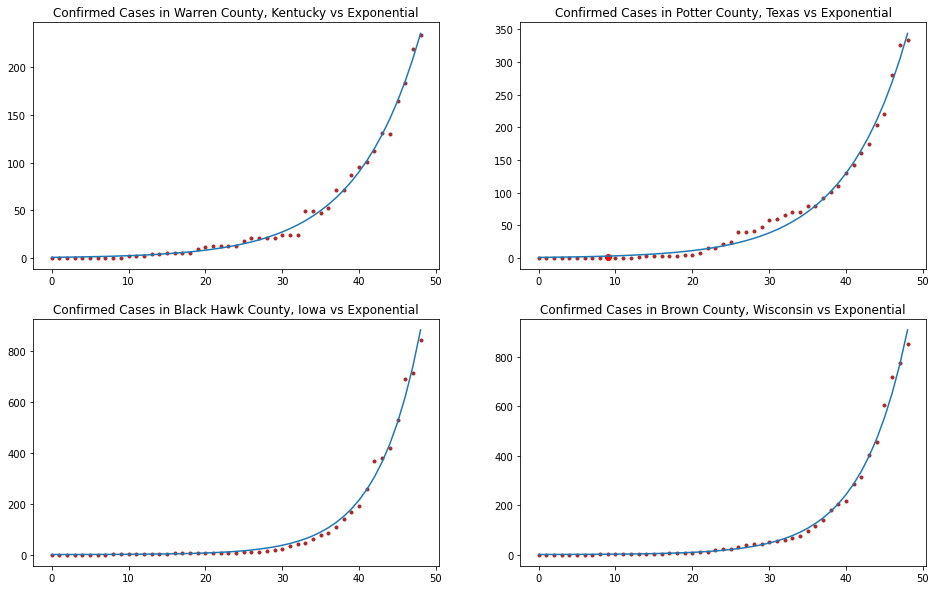

In [10]:
# The R^2 metrics divide the time series into several groups. Let's look at
# examples of each of these groups in turn.
#
# Show some example time series for which a single exponential curve
# has R^2 above 0.99
util.graph_examples(curves, ts_col_name, {"Exponential": curves["Exponential"]},
                    mask=stats['Exp_R^2'] >= r2_thresh)

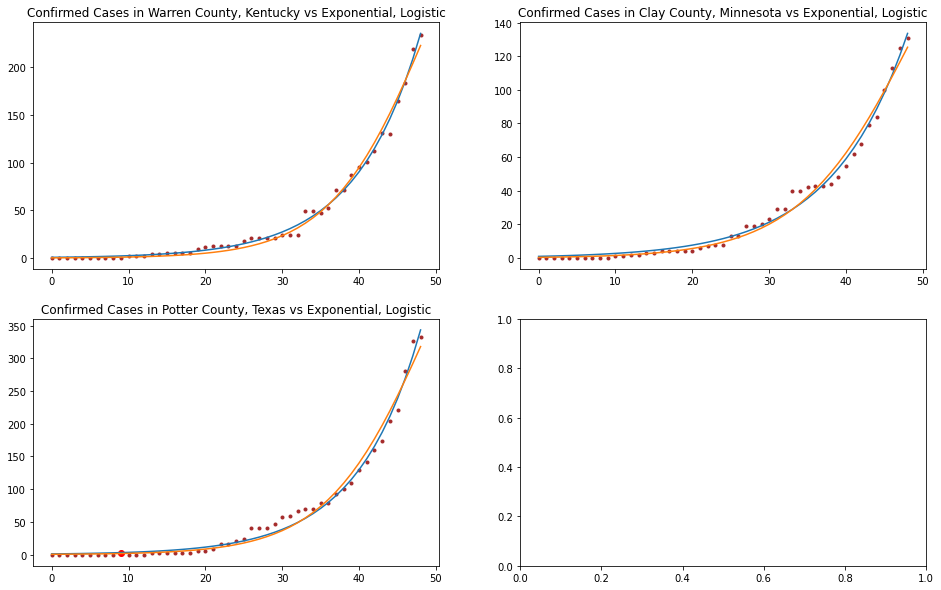

In [11]:
# Are there any time series that fit an exponential curve with R^2 > 0.99
# and fit that exponential curve *better* than they fit a logistic curve?
# util.graph_examples(curves, ts_col_name, 
#                     {"Exponential": curves["Exponential"],
#                      "Logistic": curves["Logistic"]},
#                     mask=(stats['Exp_R^2'] >= r2_thresh) & (stats['Exp_R^2'] > stats['Log_R^2']))

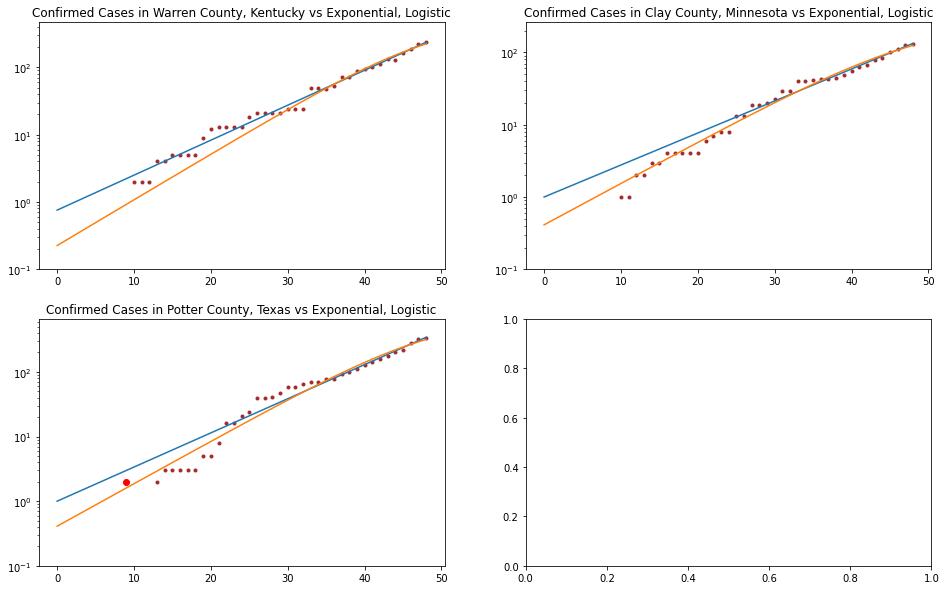

In [12]:
# Previous plots with a log scale on the Y axis
#util.graph_examples(curves, ts_col_name, 
#                    {"Exponential": curves["Exponential"],
#                     "Logistic": curves["Logistic"]},
#                    mask=(stats['Exp_R^2'] >= r2_thresh) & (stats['Exp_R^2'] > stats['Log_R^2']),
#                    semilog=True)

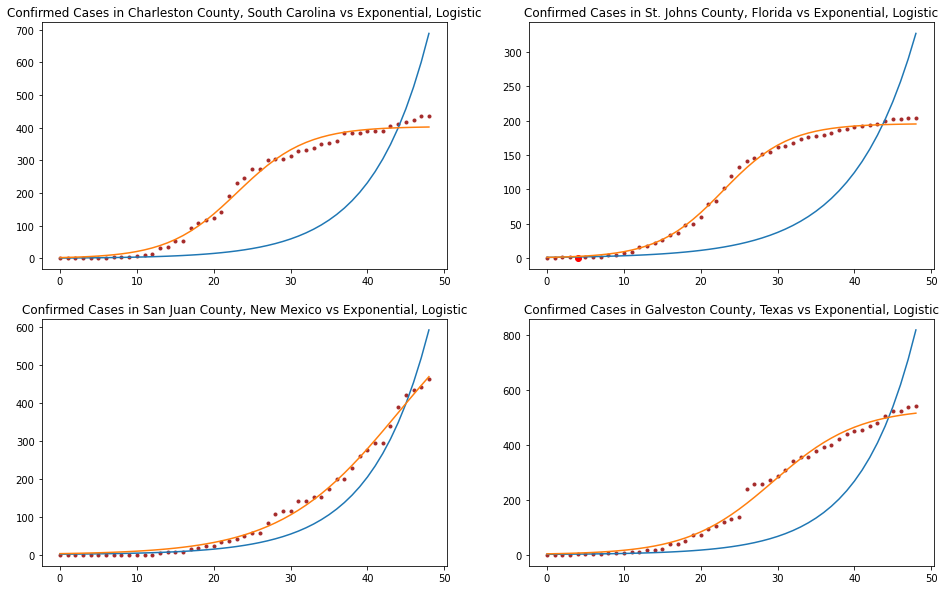

In [13]:
# Let's look at some examples where logistic growth (with a single
# instance of the logistic function) produces a good fit, while an
# exponential growth model does not.
mask = (stats['Log_R^2'] >= r2_thresh) & (stats['Exp_R^2'] < 0.95)
util.graph_examples(curves, ts_col_name, 
                    {"Exponential": curves["Exponential"],
                     "Logistic": curves["Logistic"]},
                    mask=mask)

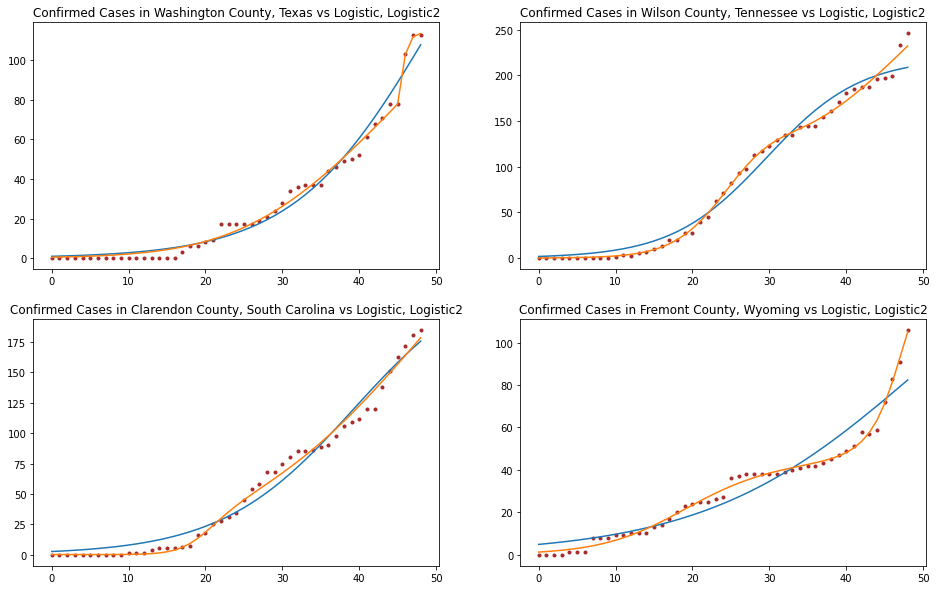

In [14]:
# Look at cases where a mixture of two logistic growth models explains
# the data better than a single logistic growth model.
mask = stats['Log2_R^2'] - stats['Log_R^2'] >= 0.01
#graph_examples(mask, {"Logistic": logistic, "Logistic2": logistic2}, num_to_pick=10)
util.graph_examples(curves, ts_col_name, 
                    {"Logistic": curves["Logistic"],
                     "Logistic2": curves["Logistic2"]},
                    mask=mask)

In [15]:
# Many of these dual-logistic curves have low values for the rate of the
# second logistic function.
# Across the entire data set, what models have logistic rate2 near zero?
small_rate2_mask = params["Log2_Rate2"] < 5e-2
params[small_rate2_mask][metadata_cols + [c for c in params.columns if c.startswith("Log2")]]

,State,County,Population,Log2_Max1,Log2_Rate1,Log2_Offset1,Log2_Max2,Log2_Rate2,Log2_Offset2,Log2_Switch_Begin,Log2_Switch_End
FIPS,,,,,,,,,,,
1073,Alabama,Jefferson,658573,1559.753826,1.257055,30.885131,1562.181125,0.047292,45.098611,10.566775,15.008162
4013,Arizona,Maricopa,4485414,1629.073075,0.261364,22.511668,6860.404645,0.040467,41.246998,32.781535,39.354349
5051,Arkansas,Garland,99386,245.041720,1.294998,33.385338,227.651533,0.035455,49.000000,16.744477,23.299216
6079,California,San Luis Obispo,283111,339.953605,0.311501,22.591127,340.247957,0.046755,49.000000,8.492455,12.063099
6081,California,San Mateo,766573,2188.277392,0.132056,33.755237,2199.333396,0.049075,49.000000,17.849132,16.849134
...,...,...,...,...,...,...,...,...,...,...,...
55025,Wisconsin,Dane,546695,816.711890,10.000000,31.894674,832.501160,0.026621,49.000000,9.965008,13.595621
55079,Wisconsin,Milwaukee,945726,1655.144102,0.209157,23.526789,5576.609116,0.042946,49.000000,25.424021,31.518334
55101,Wisconsin,Racine,196311,687.763312,1.247343,45.674397,469.304353,0.000336,45.957377,27.777855,33.867318


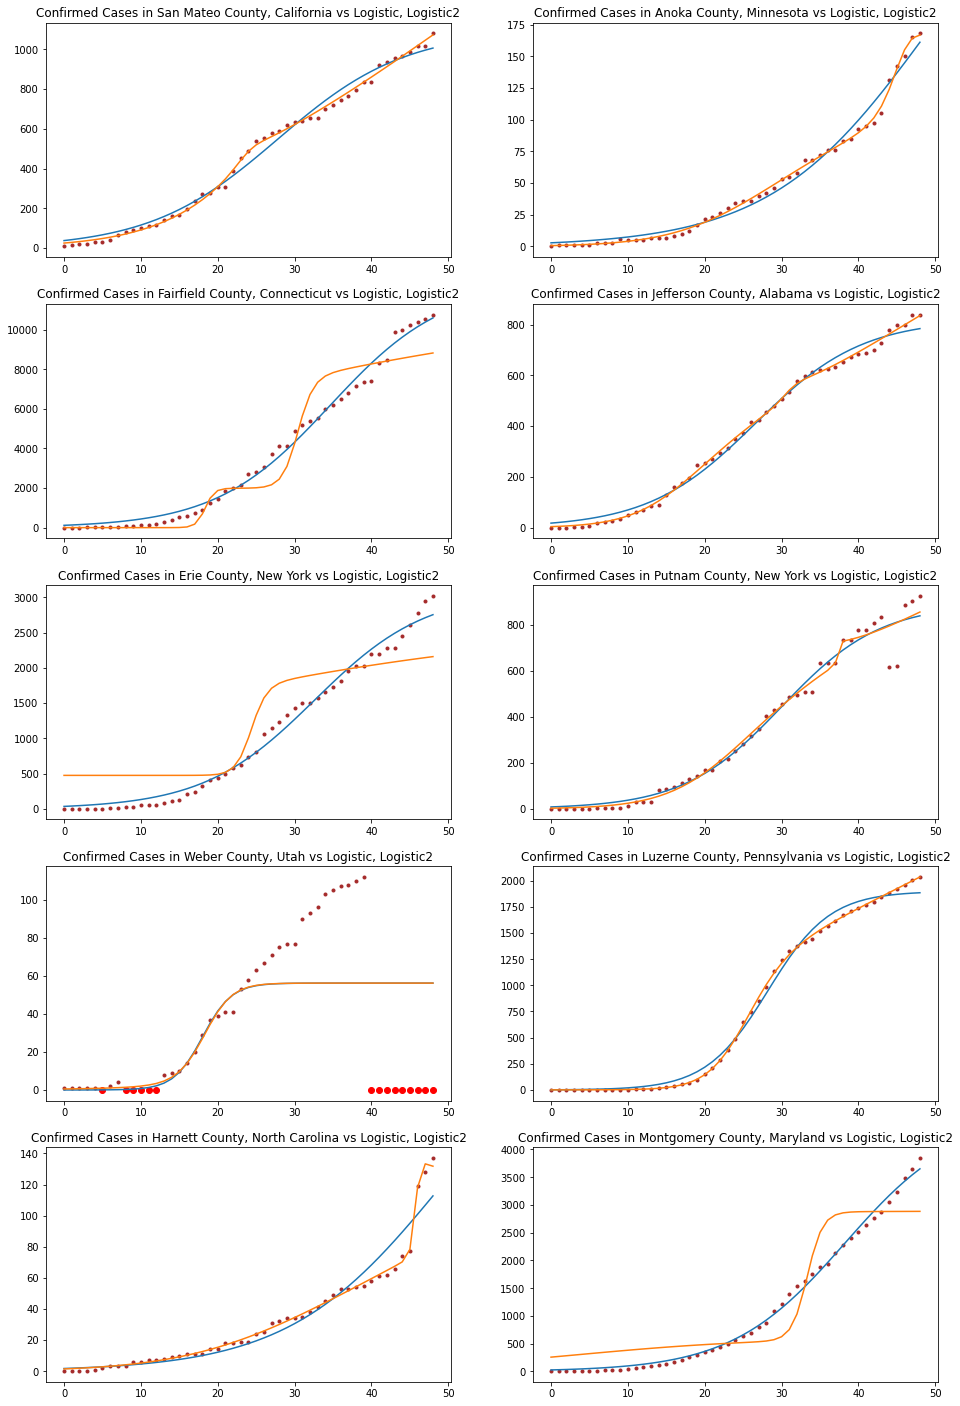

In [16]:
# Show some examples of these cases where Rate2 is small
util.graph_examples(curves, ts_col_name, 
                    {"Logistic": curves["Logistic"],
                     "Logistic2": curves["Logistic2"]},
                    mask=small_rate2_mask,
                    num_to_pick=10)

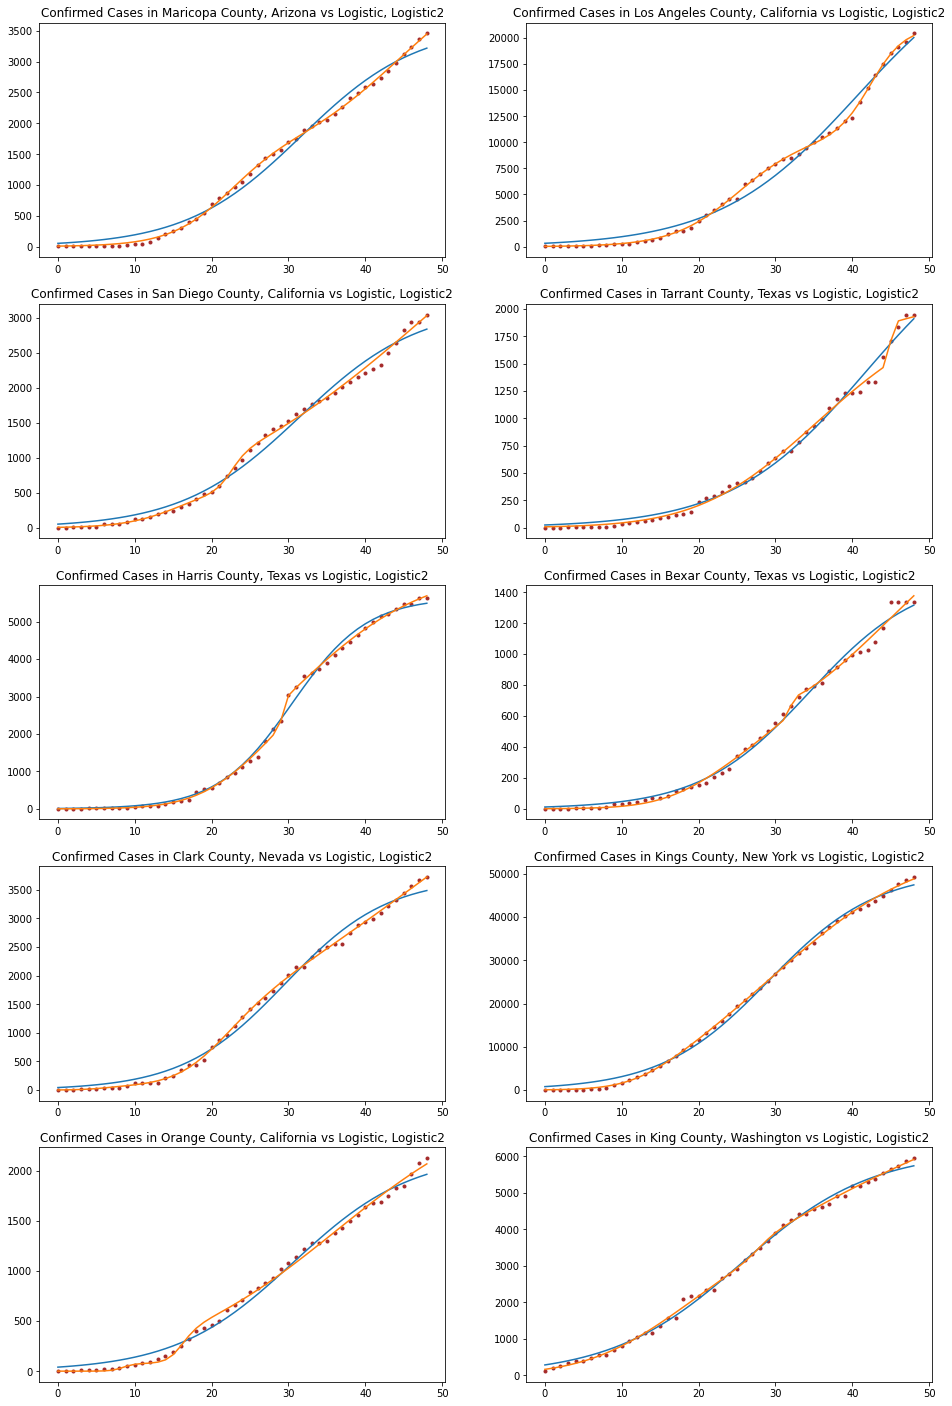

In [17]:
# What about populous counties?
util.graph_examples(curves, ts_col_name, 
                    {"Logistic": curves["Logistic"],
                     "Logistic2": curves["Logistic2"]},
                    mask=curves["Population"] > 2e6,
                    num_to_pick=10)

In [18]:
# What time series are *not* explained by any of our curves?
non_fitting_mask = (stats["Exp_R^2"] < 0.99) & (stats["Log_R^2"] < 0.99) & (stats["Log2_R^2"] < 0.99)
stats[non_fitting_mask]

,State,County,Population,Exp_R^2,Log_R^2,Log2_R^2
FIPS,,,,,,
8051,Colorado,Gunnison,17462,-0.000521,0.938972,0.977167
12035,Florida,Flagler,115081,0.934341,0.977702,0.988408
13093,Georgia,Dooly,13390,0.948596,0.981876,0.989773
18005,Indiana,Bartholomew,83779,0.840244,0.972389,0.981529
18029,Indiana,Dearborn,49458,0.583565,0.913516,0.919356
18061,Indiana,Harrison,40515,0.866601,0.982686,0.989168
20055,Kansas,Finney,36467,0.972922,0.974308,0.987804
21177,Kentucky,Muhlenberg,30622,0.955467,0.974869,0.978010
22097,Louisiana,St. Landry,82124,0.654179,0.981011,0.989969


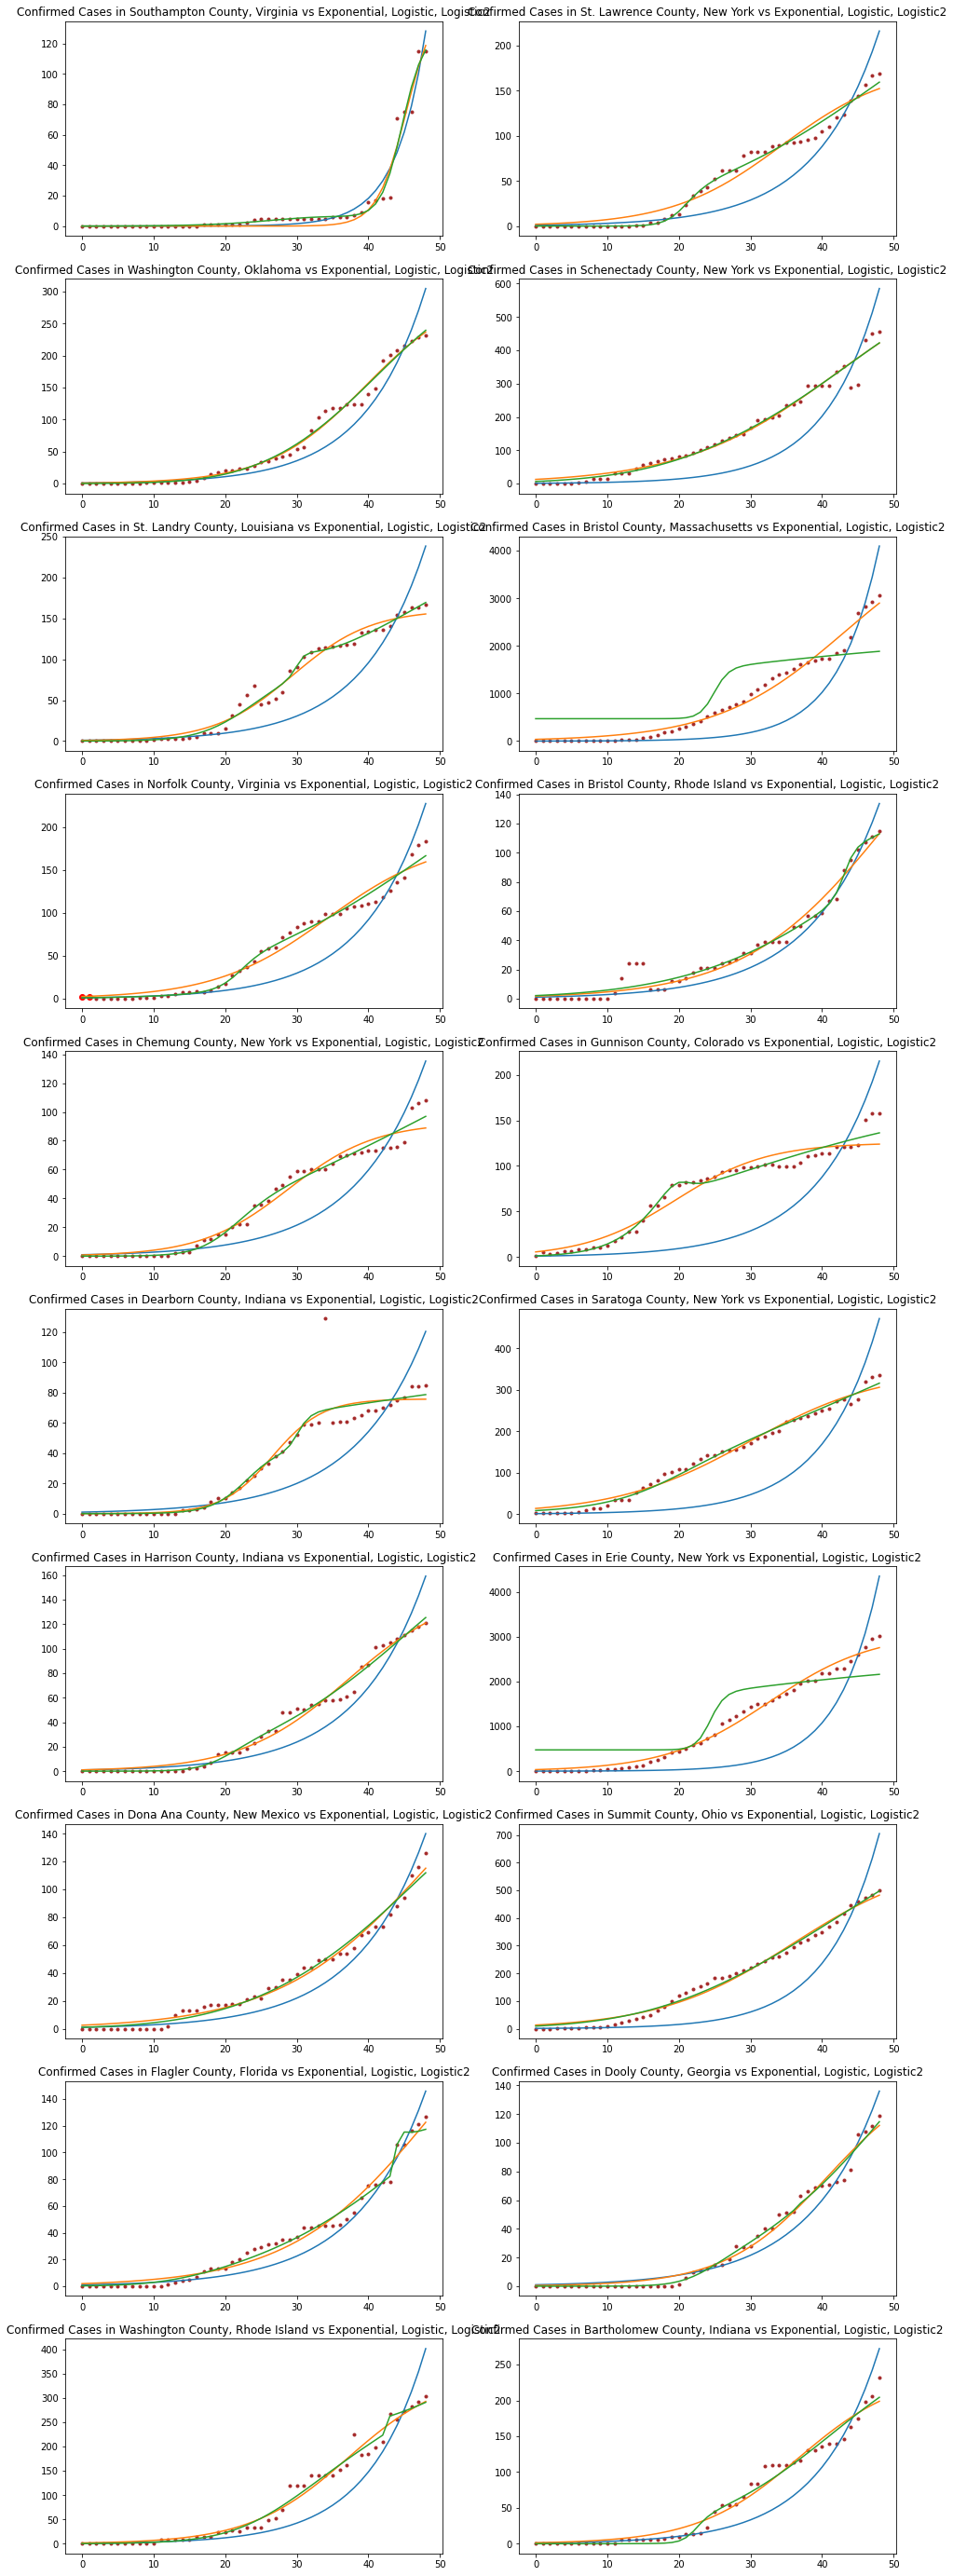

In [19]:
util.graph_examples(curves, ts_col_name, 
                    {"Exponential": curves["Exponential"],
                     "Logistic": curves["Logistic"],
                     "Logistic2": curves["Logistic2"]},
                    mask=non_fitting_mask,
                    num_to_pick=20)